# Imports

In [1]:
import os
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import networkx as nx
import random
import math
import pickle
import torch
from torch import Tensor
import pandas as pd
import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.utils import to_undirected, is_undirected, add_self_loops
import numpy as np
from networkx import to_dict_of_dicts
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, HGTLoader,NeighborSampler
from torch_geometric.utils import mask_select, index_to_mask
import pyarrow as pa
import pyarrow.parquet as pq

c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(nx.__version__)


3.2.1


In [2]:
print(torch_geometric.__version__)


2.5.3


In [2]:
print(torch.__version__)


2.2.2+cu118


In [3]:
#init cuda
device = torch.device('cuda')
device

device(type='cuda')

In [4]:
#init cuda
#device = torch.device('cpu')
#device

## Load Data


In [5]:
# import test graph
full_graph_pyg = torch.load('data/pyg_data/full_graph_hetero_data_3_nodes_rich.pt')
data = torch.load('data/pyg_data/full_graph_hetero_data_3_nodes_rich.pt')

full_graph_pyg = full_graph_pyg.to(device)
data = data.to(device)


In [7]:
# Load your saved HeteroData object
pyg_training_graph= torch.load('data/pyg_data/train_hetero_data_3_nodes_rich.pt')#
pyg_training_graph = pyg_training_graph.to(device)

In [6]:
# Load your saved HeteroData object
full_test_graph= torch.load('data/pyg_data/test_hetero_data_3_nodes_rich.pt')
full_test_graph = full_test_graph.to(device)

In [8]:
full_test_graph

HeteroData(
  users={ node_id=[3279] },
  songs={
    node_id=[155848],
    x_audio=[155848, 11],
    x_tag=[155848, 3],
  },
  artists={
    node_id=[21943],
    x_tag=[21943, 3],
  },
  (users, listens_to, songs)={ edge_index=[2, 509212521] },
  (users, is_friends_with, users)={ edge_index=[2, 141145] },
  (artists, makes, songs)={ edge_index=[2, 155848] },
  (songs, rev_listens_to, users)={ edge_index=[2, 509212521] },
  (users, rev_is_friends_with, users)={ edge_index=[2, 141145] },
  (songs, rev_makes, artists)={ edge_index=[2, 155848] }
)

In [9]:
pyg_training_graph

HeteroData(
  users={ node_id=[3307] },
  songs={
    node_id=[252013],
    x_audio=[252013, 11],
    x_tag=[252013, 3],
  },
  artists={
    node_id=[28120],
    x_tag=[28120, 3],
  },
  (users, listens_to, songs)={
    edge_index=[2, 2564907],
    edge_attr=[2564907],
  },
  (users, is_friends_with, users)={ edge_index=[2, 142919] },
  (artists, makes, songs)={ edge_index=[2, 252013] },
  (songs, rev_listens_to, users)={
    edge_index=[2, 2564907],
    edge_attr=[2564907],
  },
  (users, rev_is_friends_with, users)={ edge_index=[2, 142919] },
  (songs, rev_makes, artists)={ edge_index=[2, 252013] }
)

In [10]:
data

HeteroData(
  users={ node_id=[3307] },
  songs={
    node_id=[252013],
    x_audio=[252013, 11],
    x_tag=[252013, 3],
  },
  artists={
    node_id=[28120],
    x_tag=[28120, 3],
  },
  (users, listens_to, songs)={
    edge_index=[2, 3018207],
    edge_attr=[3018207],
  },
  (users, is_friends_with, users)={ edge_index=[2, 142919] },
  (artists, makes, songs)={ edge_index=[2, 252013] },
  (songs, rev_listens_to, users)={
    edge_index=[2, 3018207],
    edge_attr=[3018207],
  },
  (users, rev_is_friends_with, users)={ edge_index=[2, 142919] },
  (songs, rev_makes, artists)={ edge_index=[2, 252013] }
)

In [14]:
data["makes"].edge_index

tensor([[     0,      0,      0,  ...,  28117,  28118,  28119],
        [     0,      1,      2,  ..., 112259,  14295, 115034]],
       device='cuda:0')

In [23]:
data["artists"].x_tag

tensor([[17452, 17420, 10687],
        [17420, 24028, 17452],
        [17456, 17420, 11153],
        ...,
        [ 3994, 13068, 14043],
        [26399, 17452, 27798],
        [27753, 14073,    -1]], device='cuda:0')

In [11]:
data

HeteroData(
  users={ node_id=[3307] },
  songs={
    node_id=[252013],
    x_audio=[252013, 11],
    x_tag=[252013, 3],
  },
  artists={
    node_id=[28120],
    x_tag=[28120, 3],
  },
  (users, listens_to, songs)={
    edge_index=[2, 3018207],
    edge_attr=[3018207],
  },
  (users, is_friends_with, users)={ edge_index=[2, 142919] },
  (artists, makes, songs)={ edge_index=[2, 252013] },
  (songs, rev_listens_to, users)={
    edge_index=[2, 3018207],
    edge_attr=[3018207],
  },
  (users, rev_is_friends_with, users)={ edge_index=[2, 142919] },
  (songs, rev_makes, artists)={ edge_index=[2, 252013] }
)

In [ ]:
# Check max and min node IDs for all nodes and edges
max_user_node_id = data['users'].node_id.max()
min_user_node_id = data['users'].node_id.min()
max_song_node_id = data['songs'].node_id.max()
min_song_node_id = data['songs'].node_id.min()
max_artist_node_id = data['artists'].node_id.max()
min_artist_node_id = data['artists'].node_id.min()

listens_to_edge_index = data['users', 'listens_to', 'songs'].edge_index
max_listens_to_edge_id_0 = listens_to_edge_index[0].max()
min_listens_to_edge_id_0 = listens_to_edge_index[0].min()
max_listens_to_edge_id_1 = listens_to_edge_index[1].max()
min_listens_to_edge_id_1 = listens_to_edge_index[1].min()

is_friends_with_edge_index = data['users', 'is_friends_with', 'users'].edge_index
max_is_friends_with_edge_id_0 = is_friends_with_edge_index[0].max()
min_is_friends_with_edge_id_0 = is_friends_with_edge_index[0].min()
max_is_friends_with_edge_id_1 = is_friends_with_edge_index[1].max()
min_is_friends_with_edge_id_1 = is_friends_with_edge_index[1].min()

makes_edge_index = data['artists', 'makes', 'songs'].edge_index
max_makes_edge_id_0 = makes_edge_index[0].max()
min_makes_edge_id_0 = makes_edge_index[0].min()
max_makes_edge_id_1 = makes_edge_index[1].max()
min_makes_edge_id_1 = makes_edge_index[1].min()

print(f'Max User Node ID: {max_user_node_id}, Min User Node ID: {min_user_node_id}')
print(f'Max Song Node ID: {max_song_node_id}, Min Song Node ID: {min_song_node_id}')
print(f'Max Artist Node ID: {max_artist_node_id}, Min Artist Node ID: {min_artist_node_id}')
print(f'Max Listens To Edge ID (0): {max_listens_to_edge_id_0}, Min Listens To Edge ID (0): {min_listens_to_edge_id_0}')
print(f'Max Listens To Edge ID (1): {max_listens_to_edge_id_1}, Min Listens To Edge ID (1): {min_listens_to_edge_id_1}')
print(f'Max Is Friends With Edge ID (0): {max_is_friends_with_edge_id_0}, Min Is Friends With Edge ID (0): {min_is_friends_with_edge_id_0}')
print(f'Max Is Friends With Edge ID (1): {max_is_friends_with_edge_id_1}, Min Is Friends With Edge ID (1): {min_is_friends_with_edge_id_1}')
print(f'Max Makes Edge ID (0): {max_makes_edge_id_0}, Min Makes Edge ID (0): {min_makes_edge_id_0}')
print(f'Max Makes Edge ID (1): {max_makes_edge_id_1}, Min Makes Edge ID (1): {min_makes_edge_id_1}')


Max User Node ID: 3306, Min User Node ID: 0
Max Song Node ID: 252012, Min Song Node ID: 0
Max Artist Node ID: 28119, Min Artist Node ID: 0
Max Listens To Edge ID (0): 3306, Min Listens To Edge ID (0): 0
Max Listens To Edge ID (1): 252012, Min Listens To Edge ID (1): 0
Max Is Friends With Edge ID (0): 3306, Min Is Friends With Edge ID (0): 0
Max Is Friends With Edge ID (1): 3306, Min Is Friends With Edge ID (1): 0
Max Makes Edge ID (0): 28119, Min Makes Edge ID (0): 0
Max Makes Edge ID (1): 252012, Min Makes Edge ID (1): 0


# Preparing Data

In [12]:
## Set up Message and Supervision Edges
import torch
from torch_geometric.utils import to_undirected, is_undirected
from tqdm import tqdm

full_graph = full_graph_pyg

# Get the edge indices for the 'users', 'listens_to', 'songs' relation
full_edge_index = full_graph['users', 'listens_to', 'songs'].edge_index
train_edge_index = pyg_training_graph['users', 'listens_to', 'songs'].edge_index

# Create masks for training and test edges
train_mask = torch.zeros(full_edge_index.size(1), dtype=torch.bool)
test_mask = torch.zeros(full_edge_index.size(1), dtype=torch.bool)

# Find the indices of the training edges in the full graph
train_edge_set = set(map(tuple, train_edge_index.t().tolist()))

for i, edge in enumerate(tqdm(full_edge_index.t().tolist())):
    if tuple(edge) in train_edge_set:
        train_mask[i] = True

# Assign masks to the full graph
full_graph['users', 'listens_to', 'songs'].train_mask = train_mask
full_graph['users', 'listens_to', 'songs'].test_mask = test_mask

# Set up edge_label_index and edge_label for training and validation
pyg_training_graph['users', 'listens_to', 'songs'].edge_label_index = train_edge_index
pyg_training_graph['users', 'listens_to', 'songs'].edge_label = torch.ones(train_edge_index.size(1))

100%|██████████| 3018207/3018207 [00:06<00:00, 473566.62it/s]


## Set Up Supervision Edges for each Split
These edges are used not for message passing but for evaluating the models performance and holding ground truths


In [14]:
train_index = pyg_training_graph['users', 'listens_to', 'songs'].edge_label_index[:, :int(2564907 * 0.9)]
val_index = pyg_training_graph['users', 'listens_to', 'songs'].edge_label_index[:, int(2564907 * 0.9):]

In [15]:
val_index, val_index.shape,train_index.shape, len(val_index[0]) + len(train_index[0])

(tensor([[  2876,   2876,   2876,  ...,   3306,   3306,   3306],
         [ 45027, 127926,  49063,  ...,    508,   8884, 170124]],
        device='cuda:0'),
 torch.Size([2, 256491]),
 torch.Size([2, 2308416]),
 2564907)

# Samplers

In [16]:
kwargs = dict(  # Shared data loader arguments:
    num_neighbors=[5, 5, 5],
    #batch_size=256,
    batch_size=1024,
    num_workers=8,
    persistent_workers=True,
)

## Train Loader

In [17]:
train_loader = LinkNeighborLoader(
    data=full_graph_pyg,
    edge_label_index=(('users', 'listens_to', 'songs' ), train_index),
    neg_sampling = dict(mode='binary'),
    shuffle=True,
    **kwargs,
)

## Val Loader

In [28]:
val_loader = LinkNeighborLoader(
    data=full_graph_pyg,
    edge_label_index=(('users', 'listens_to', 'songs' ), val_index),
    neg_sampling = dict(mode='binary'),
    shuffle=True,
    **kwargs,
)

# Distance Function
Precompute Distances for Costum Loss Function
The cosines from the User and Track embeddings are used to precomupte distances between all users and songs, that serve as a variable in the loss function of the model training.
This is according to the MRcury Model I am replicating. 

In [19]:
if 'cos' not in locals():
    cosines = np.load('data/embeddings/cosines/cos.npz')['cosines']
    cos = cosines

In [20]:
import torch
from torch_geometric.utils import add_self_loops
from tqdm import tqdm

users = data["users"].node_id

def compute_distance_pyg(edge_label_index, node_id):
    sim = []
    
    for u_node in tqdm(range(node_id.size(0))):
        # Get neighbor indices #second bracket is a mask that selects only edges for which boolean holds True!
        neighbor_indices = edge_label_index[1][edge_label_index[0] == u_node]  
        # Iterate through neighbors
        for t_neighbor in neighbor_indices:
            #append sim
            sim.append(cos[u_node, t_neighbor])
            
    sim = np.asarray(sim)
    mean = np.mean(sim)
    std = np.std(sim)
    dut = np.clip(1 - (cos - (mean - 2 * std)) / (4 * std), 0.1, 0.9)
    return dut

In [21]:
import os

# Define the path variable
dut_path = 'data/embeddings/cosines/dut.npy'

# Check if dut is already saved
if os.path.exists(dut_path):
    dut = np.load(dut_path)
    print(f"Successfully loaded dut from {dut_path}")
else:
    dut = compute_distance_pyg(data['users', 'listens_to', 'songs']["edge_index"], users)
    # Save dut if it doesn't exist
    np.save(dut_path, dut)
    print(f"Successfully computed and saved dut to {dut_path}")


100%|██████████| 3307/3307 [01:05<00:00, 50.38it/s] 


Successfully computed and saved dut to data/embeddings/cosines/dut.npy


# Models

## Model 1: Shallow

In [29]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
class GNN(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x
    
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_songs: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_song = x_songs[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_song).sum(dim=-1)

class Model_Shallow(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        
        #self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["users"].num_nodes, hidden_channels)
        self.song_emb = torch.nn.Embedding(data["songs"].num_nodes, hidden_channels)
        self.artist_emb = torch.nn.Embedding(data["artists"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()
        
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "users": self.user_emb(data["users"].n_id),
          "songs": self.song_emb(data["songs"].n_id),
          "artists": self.artist_emb(data["artists"].n_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["users"],
            x_dict["songs"],
            data["users", "listens_to", "songs"].edge_label_index,
        )
        return pred
        
model_shallow = Model_Shallow(hidden_channels=64).to(device)


## Model 2: Rich

In [30]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return x
    
class InnerProductDecoder(torch.nn.Module):
    def forward(self, x_user: Tensor, x_songs: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_song = x_songs[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_song).sum(dim=-1)
    

class Model_Rich(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Initialize embeddings for users, songs, and artists
        self.user_emb = torch.nn.Embedding(data["users"].num_nodes, hidden_channels)
        self.artist_emb = torch.nn.Embedding(data["artists"].num_nodes, hidden_channels)
        
        # Instantiate the GNN with three layers
        self.encoder = GNN(hidden_channels)
        
        # Convert GNN model into a heterogeneous variant
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        
        # Initialize the decoder
        self.decoder = InnerProductDecoder()

    def forward(self, data: HeteroData) -> Tensor:
        # Initialize node features using embeddings and additional data for artists
        x_dict = {
            "users": self.user_emb(data["users"].node_id),
            "songs": torch.cat((data["songs"].x_audio, data["songs"].x_tag), dim=-1),
            "artists": torch.cat((self.artist_emb(data["artists"].node_id), data["artists"].x_tag), dim=-1),
        }
        
        # Pass the node features and edge indices through the GNN
        x_dict = self.encoder(x_dict, data.edge_index_dict)
        
        # Compute predictions using the decoder
        pred = self.decoder(
            x_dict["users"],
            x_dict["songs"],
            #x_dict["artists"],
            data["users", "listens_to", "songs"].edge_label_index,
        )
        return pred
    
model_rich = Model_Rich(hidden_channels=64).to(device)


# Training

## Binary Entropy Loss

In [31]:
# Training Loop
def train(model, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    total_loss = total_examples = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        y = batch['users', 'listens_to', 'songs'].edge_label

        loss = F.binary_cross_entropy_with_logits(out, y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * y.numel()
        total_examples += y.numel()

    return total_loss / total_examples

### With validation

In [32]:
@torch.no_grad()
def validate(model, val_loader):
    model.eval()
    total_loss = total_examples = 0
    for batch in tqdm(val_loader, desc="Validation"):
        batch = batch.to(device)
        out = model(batch)
        y = batch['users', 'listens_to', 'songs'].edge_label

        # Use the same loss function as in training
        loss = F.binary_cross_entropy_with_logits(out, y)
        
        total_loss += float(loss) * y.numel()
        total_examples += y.numel()

    return total_loss / total_examples

In [33]:
def train_and_validate(model, train_loader, val_loader, optimizer, model_path, epochs):
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path))
            print("Model loaded successfully. Skipping training.")
        except Exception as e:
            print(f"Failed to load model: {e}. Proceeding with training.")

    else:    
        train_losses = []
        val_losses = []
        for epoch in range(1, epochs + 1):
            # Training phase
            model.train()
            total_loss = total_examples = 0
            for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                y = batch['users', 'listens_to', 'songs'].edge_label

                loss = F.binary_cross_entropy_with_logits(out, y)
                loss.backward()
                optimizer.step()

                total_loss += float(loss) * y.numel()
                total_examples += y.numel()

            train_loss = total_loss / total_examples
            train_losses.append(train_loss)
            print(f'Epoch {epoch:02d}, Training Loss: {train_loss:.4f}')

            # Validation phase
            val_loss = validate(model, val_loader)
            val_losses.append(val_loss)
            print(f'Epoch {epoch:02d}, Validation Loss: {val_loss:.4f}')
            
        torch.save(model.state_dict(), model_path)
        
        # Exporting training and validation losses to CSV
        losses_df = pd.DataFrame({'Epoch': range(1, epochs + 1), 'Training Loss': train_losses, 'Validation Loss': val_losses})
        losses_df.to_csv(f'{model_path}_losses.csv', index=False)
        print(f"Training and validation losses saved to {model_path}_losses.csv")

In [34]:
# Shallow Model
optimizer = torch.optim.Adam(model_shallow.parameters(), lr=0.001)
model_path = 'data/gnn_models/model_shallow_ep10_binary_loss_w_val.pth'
train_and_validate(model = model_shallow, 
                   train_loader = train_loader, 
                   val_loader = val_loader, 
                   optimizer = optimizer, 
                   model_path = model_path, 
                   epochs = 10
                   )

Model loaded successfully. Skipping training.


In [35]:
# Rich Model
optimizer = torch.optim.Adam(model_rich.parameters(), lr=0.001)
model_path = 'data/gnn_models/model_rich_ep10_binary_loss_w_val.pth'
train_and_validate(model = model_rich,
                   train_loader = train_loader, 
                   val_loader = val_loader, 
                   optimizer = optimizer, 
                   model_path = model_path, 
                   epochs = 10
                   )

Model loaded successfully. Skipping training.


## Costum Loss

Function that exctracts the subset of the precomputed distances only for the relevant users in the current training batch

In [36]:
def select_distances_for_users(dut, edge_label_index):
        """
        Selects the subset of precomputed distances for all users based on the edge_label_index.

        Args:
        - dut (numpy array): Precomputed distances.
        - edge_label_index (numpy array): Edge label index with user id in the first dimension and song node id in the second dimension.

        Returns:
        - selected_distances (numpy array): Subset of distances for all users and edge_label_index.
        """
        all_users_distances = []
        
        
        edge_label_index = edge_label_index
        
        # Iterate over each user in the edge_label_index
        for i,user_id in enumerate(edge_label_index[0]):
            # Filter distances for the current user
            user_distances = dut[user_id]
            
            # Filter distances based on edge_label_index for the current users according song node
            selected_user_distances = user_distances[edge_label_index[1][i]]
            
            # Append the selected distances for the current user to the list
            all_users_distances.append(selected_user_distances)
        
        # Convert the list of selected distances to a numpy array
        selected_distances = np.array(all_users_distances)
        
        return selected_distances  

The Costum Loss Function as defined by the MRecruy Paper

In [37]:
def custom_loss(y_true, y_pred, d, beta):
    # Ensure all inputs are tensors on the correct device
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    d = torch.from_numpy(d).to(device)  # Convert numpy array to tensor
    
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-8
    
    # Compute the loss
    loss = torch.mean(d ** beta * F.mse_loss(y_pred, torch.log(2 * y_true + epsilon) / torch.log(torch.tensor(2.0))))
    
    return loss

Training Loop

In [38]:
@torch.no_grad()
def validate_custom_loss(model, val_loader, dut, beta=0.75):
    model.eval()
    total_loss = total_examples = 0

    for batch in tqdm(val_loader, desc="Validation"):
        batch = batch.to(device)
        out = model(batch)
        y = batch['users', 'listens_to', 'songs'].edge_label

        # Select distances for users
        selected_distances = select_distances_for_users(dut, batch['users', 'listens_to', 'songs'].edge_label_index)

        # Use the custom loss function
        loss = custom_loss(y, out, selected_distances, beta)
        
        total_loss += float(loss) * y.numel()
        total_examples += y.numel()

    avg_loss = total_loss / total_examples
       
    return avg_loss

In [39]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import os

def train_model(model, epochs=10, learning_rate=0.001, model_path = 'data/gnn_models'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_loss = total_examples = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_examples = 0
        for sampled_data in tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data = sampled_data.to(device)
            
            # Forward pass
            pred = model(sampled_data)
            
            ground_truth = sampled_data['users', 'listens_to', 'songs'].edge_label
            
            # Select distances for users
            selected_distances = select_distances_for_users(dut, sampled_data['users', 'listens_to', 'songs'].edge_label_index)
            
            # Compute the custom loss
            beta = 0.75
            loss = custom_loss(ground_truth, pred, selected_distances, beta)
            
            loss.backward()
            optimizer.step()
            
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        
        train_loss = total_loss / total_examples
        train_losses.append(train_loss)
        print(f'Epoch {epoch:02d}, Training Loss: {train_loss:.4f}')

        # Validation phase
        val_loss = validate_custom_loss(model, val_loader, dut, beta)
        val_losses.append(val_loss)
        print(f'Epoch {epoch:02d}, Validation Loss: {val_loss:.4f}')
    
    # Save train and val losses to a CSV file in the same directory as the model saves
    losses_df = pd.DataFrame({'Epoch': range(1, epochs + 1), 'Training Loss': train_losses, 'Validation Loss': val_losses})
    losses_csv_path = f'{model_path}_losses.csv'
    losses_df.to_csv(losses_csv_path, index=False)
    print(f'Losses saved to {losses_csv_path}')

init untrained models to make sure no overlapping with other training happens

In [40]:
model_shallow_costum = Model_Shallow(hidden_channels=64).to(device)
model_rich_costum = Model_Rich(hidden_channels=64).to(device)

Train Models

In [41]:
model_path = 'data/gnn_models/model_shallow_ep10_custom_loss_w_val.pth'
if os.path.exists(model_path):
    model_shallow_costum.load_state_dict(torch.load(model_path))
    print("Model loaded successfully. Skipping training.")
else:
    train_model(model_shallow_costum, epochs=10, model_path = model_path)
    torch.save(model_shallow_costum.state_dict(), model_path)

Model loaded successfully. Skipping training.


In [42]:
model_path = 'data/gnn_models/model_rich_ep10_custom_loss_w_val.pth'
if os.path.exists(model_path):
    model_rich_costum.load_state_dict(torch.load(model_path))
    print("Model loaded successfully. Skipping training.")
else:
    train_model(model_rich_costum, epochs=10, model_path = model_path)
    torch.save(model_rich_costum.state_dict(), model_path)

Model loaded successfully. Skipping training.


==================================

Val Loss is always worse for "shallow" models. 
Rich models show worse training loss than shallow models, but their validation loss does not strive too far from their training loss. Suggesting they do not overfit as much as the shallow models do. 
Overall the val loss of shallow is even Higher than to their rich counterpart. Meaning shallow models may perform better at training loss, but overfit easily.

Costum Loss is worse, and Rich model is worse. Suggests that Rioch model = more features, in graph NNs does not necessarily yield better results = more in depth data NOT always better results. ~ is relativized by the statement above. Maybe true on train data but not on val data. Results on Test data remain to be seen. 

# Validation

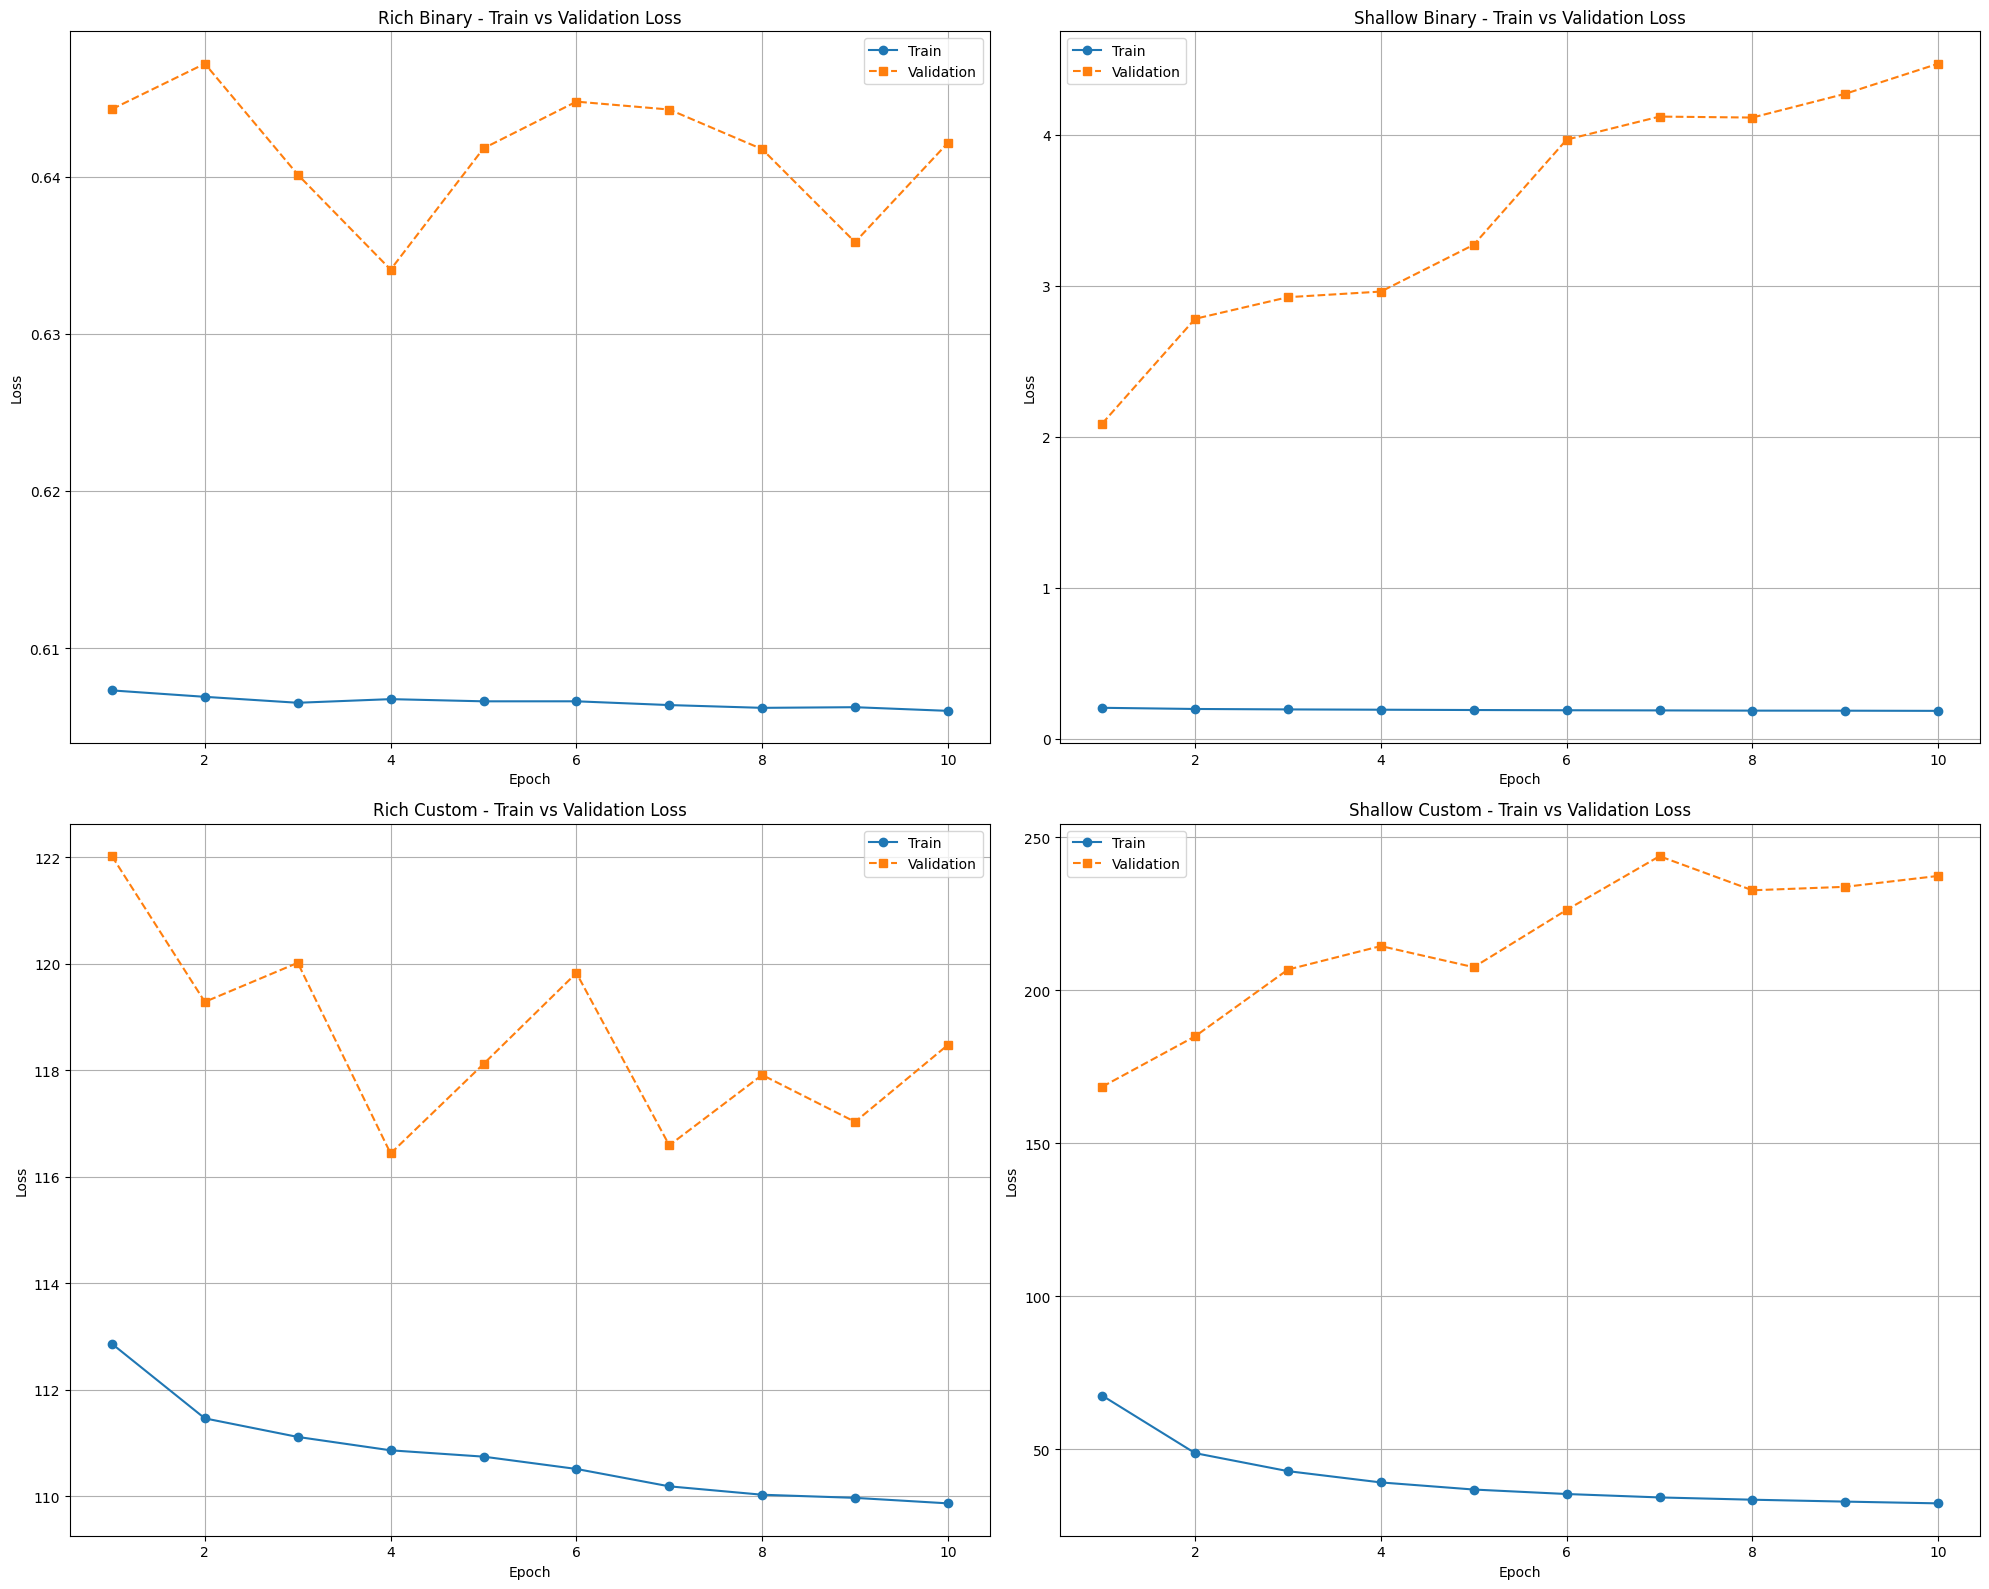

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

model_paths = {
    'Rich Binary': "data/gnn_models/model_rich_ep10_binary_loss_w_val.pth_losses.csv",
    'Shallow Binary': "data/gnn_models/model_shallow_ep10_binary_loss_w_val.pth_losses.csv",
    'Rich Custom': "data/gnn_models/model_rich_ep10_custom_loss_w_val.pth_losses.csv",
    'Shallow Custom': "data/gnn_models/model_shallow_ep10_custom_loss_w_val.pth_losses.csv"
}

fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.ravel()

for idx, (model_name, path) in enumerate(model_paths.items()):
    df = pd.read_csv(path)
    ax = axs[idx]
    ax.plot(df['Epoch'], df['Training Loss'], label='Train', marker='o')
    ax.plot(df['Epoch'], df['Validation Loss'], label='Validation', linestyle='--', marker='s')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name} - Train vs Validation Loss')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

Normalized for all values

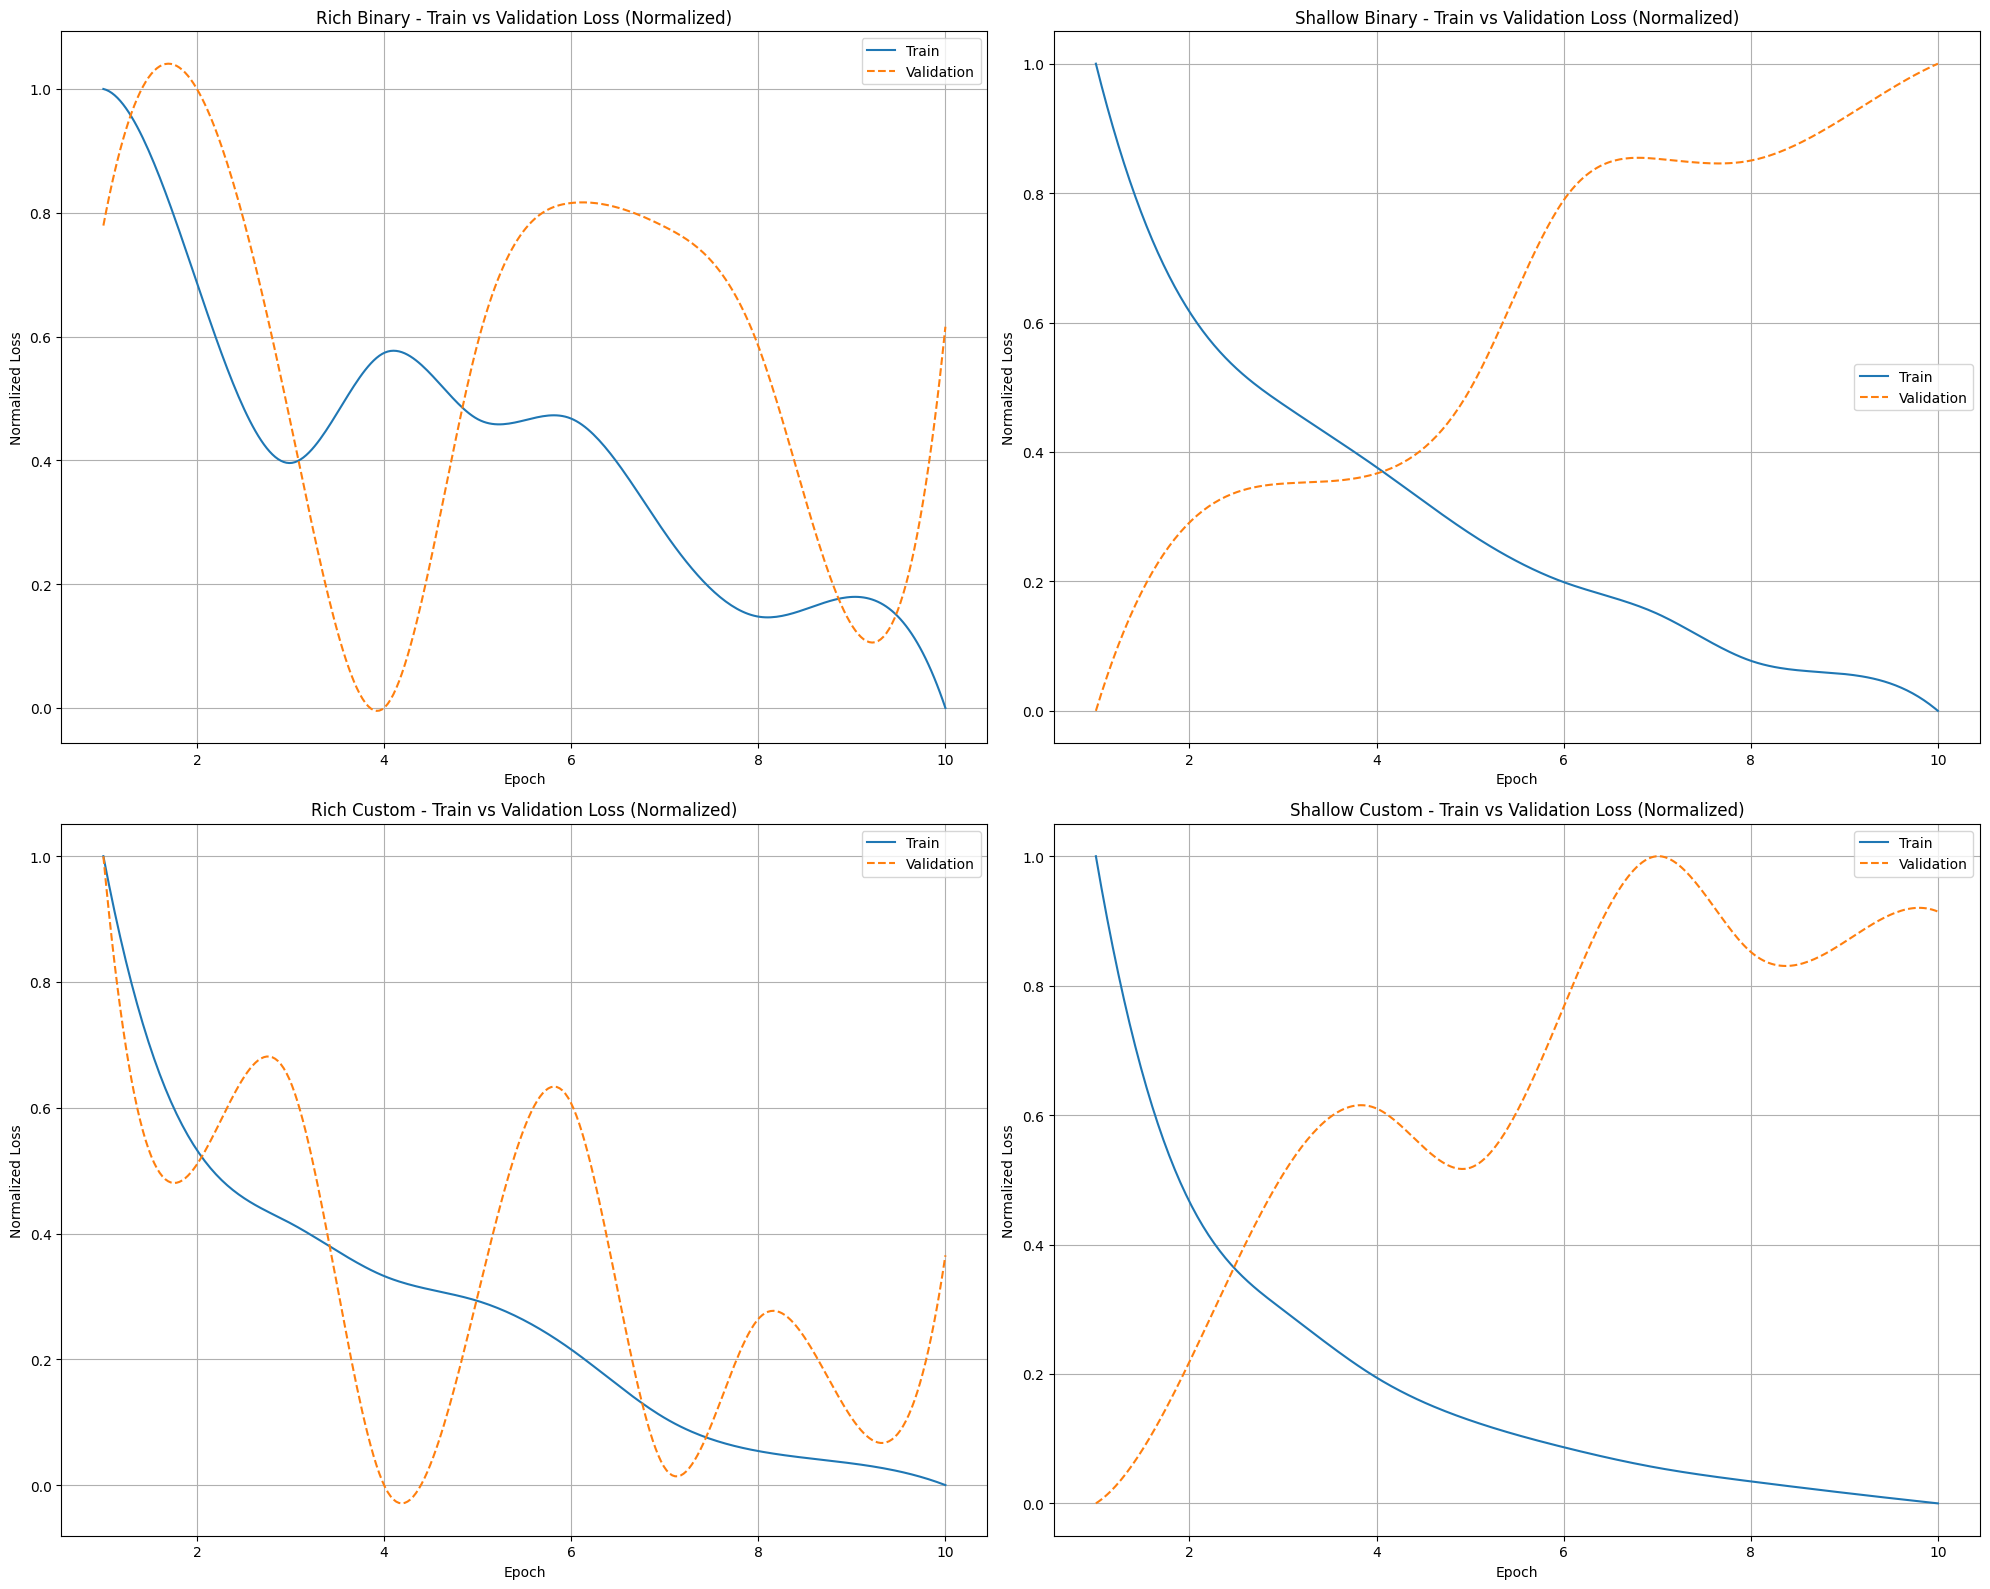

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline

model_paths = {
    'Rich Binary': "data/gnn_models/model_rich_ep10_binary_loss_w_val.pth_losses.csv",
    'Shallow Binary': "data/gnn_models/model_shallow_ep10_binary_loss_w_val.pth_losses.csv",
    'Rich Custom': "data/gnn_models/model_rich_ep10_custom_loss_w_val.pth_losses.csv",
    'Shallow Custom': "data/gnn_models/model_shallow_ep10_custom_loss_w_val.pth_losses.csv"
}

fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.ravel()

scaler = MinMaxScaler()

for idx, (model_name, path) in enumerate(model_paths.items()):
    df = pd.read_csv(path)
    
    # Normalize the loss values
    df[['Training Loss', 'Validation Loss']] = scaler.fit_transform(df[['Training Loss', 'Validation Loss']])
    
    ax = axs[idx]
    
    # Create smooth curves
    x_smooth = np.linspace(df['Epoch'].min(), df['Epoch'].max(), 300)
    for column in ['Training Loss', 'Validation Loss']:
        spline = make_interp_spline(df['Epoch'], df[column], k=3)
        y_smooth = spline(x_smooth)
        
        if column == 'Training Loss':
            ax.plot(x_smooth, y_smooth, label='Train')
        else:
            ax.plot(x_smooth, y_smooth, label='Validation', linestyle='--')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Normalized Loss')
    ax.set_title(f'{model_name} - Train vs Validation Loss (Normalized)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Testing

### Full Test Loader

In [ ]:
full_test_graph['users', 'listens_to', 'songs'].edge_label_index  = full_test_graph['users', 'listens_to', 'songs'].edge_index

full_test_label_index = full_test_graph['users', 'listens_to', 'songs'].edge_label_index

edge_labels = torch.ones(full_test_label_index.size(1))

In [41]:
kwargs = dict(  # Shared data loader arguments:
    num_neighbors=[5, 5, 5],
    #batch_size=524,
    num_workers=4,
    persistent_workers=False,
) 

# test loader with negative edges ratio 1, loading data in batches
full_test_loader = LinkNeighborLoader(
    data= full_test_graph,
    edge_label_index= (('users', 'listens_to', 'songs'), full_test_label_index),
    edge_label= edge_labels,  #  test edges labeled as 1
    #neg_sampling=dict(mode='binary', amount=1),  # 1:1 Neg Sampling Ratio
    shuffle=False,
    **kwargs,
    batch_size=40000,  # Adjust batch size based on available memory
)

## Testing Function
Carefull. This needs a lot of space on disk ~15GB per Model. Be sure you have enough Space if you run this. RAM managment not perfect - could be the case that this needs to be re-run , but it should pick up with the files from disk after RAM errors.

In [42]:
# Define the class for testing and evaluation
class ModelTester:
    def __init__(self, model, test_loader, output_dir, device='cuda'):
        print("=====================================================")
        print("Initializing ModelTester with model, test_loader, output_dir, and device.")
        self.model = model.to(device)
        self.test_loader = test_loader
        self.output_dir = output_dir
        self.device = device

    @torch.no_grad()
    def test_evaluation(self, model_name):
        print(f"Starting test evaluation for model: {model_name}")
        self.model.eval()
        preds = []
        ground_truths = []
        node_a = [] 
        node_b = []
        
        # Create a unique directory for each model's batch saves
        model_output_dir = os.path.join(self.output_dir, model_name)
        os.makedirs(model_output_dir, exist_ok=True)  # Ensure the directory exists
        batch_counter = 0

        for batch in tqdm(self.test_loader):
            batch = batch.to(self.device)
            raw_preds = self.model(batch)
            preds.append(raw_preds.cpu().numpy())
            ground_truths.append(batch['users', 'listens_to', 'songs'].edge_label.cpu().numpy())
            edge_label_index = batch['users', 'listens_to', 'songs'].edge_label_index
            cur_node_a = np.array(batch["users"].n_id.cpu())[edge_label_index[0].cpu()]
            cur_node_b = np.array(batch["songs"].n_id.cpu())[edge_label_index[1].cpu()]
            node_a.append(cur_node_a)
            node_b.append(cur_node_b)

            if len(preds) >= 1000:
                self._save_intermediate_results(preds, ground_truths, node_a, node_b, batch_counter, model_output_dir)
                preds, ground_truths, node_a, node_b = [], [], [], []
                batch_counter += 1

        if preds:
            self._save_intermediate_results(preds, ground_truths, node_a, node_b, batch_counter, model_output_dir)

        print(f"Data saved in {model_output_dir}")

    def _save_intermediate_results(self, preds, ground_truths, node_a, node_b, batch_counter, output_dir):
        print(f"Saving intermediate results for batch {batch_counter} in {output_dir}")
        np.save(os.path.join(output_dir, f'preds_{batch_counter}.npy'), np.concatenate(preds))
        np.save(os.path.join(output_dir, f'ground_truths_{batch_counter}.npy'), np.concatenate(ground_truths))
        np.save(os.path.join(output_dir, f'node_a_{batch_counter}.npy'), np.concatenate(node_a))
        np.save(os.path.join(output_dir, f'node_b_{batch_counter}.npy'), np.concatenate(node_b))
        # Free memory
        #del preds, ground_truths, node_a, node_b

    def load_evaluation_data(self, model_name):
        print(f"Loading evaluation data for model: {model_name}")
        preds = []
        ground_truths = []
        node_a = []
        node_b = []

        model_output_dir = os.path.join(self.output_dir, model_name)
        files = os.listdir(model_output_dir)
        for file in files:
            if file.startswith('preds_'):
                preds.append(np.load(os.path.join(model_output_dir, file)))
            elif file.startswith('ground_truths_'):
                ground_truths.append(np.load(os.path.join(model_output_dir, file)))
            elif file.startswith('node_a_'):
                node_a.append(np.load(os.path.join(model_output_dir, file)))
            elif file.startswith('node_b_'):
                node_b.append(np.load(os.path.join(model_output_dir, file)))

        preds = np.concatenate(preds)
        preds = (preds - preds.min()) / (preds.max() - preds.min()).round(3)
        ground_truths = np.concatenate(ground_truths)
        node_a = np.concatenate(node_a)
        node_b = np.concatenate(node_b)

        test_edges = np.array([node_a, node_b])
        return preds, ground_truths, test_edges
        # Free memory
        #del node_a, node_b

    def sort_user_predictions(self, predictions_df, model_name):
        print("Sorting user predictions")
        parquet_path = f'data/gnn_models/1.test_matrix_predictions/predictions/predictions_{model_name}.parquet'
        csv_path = f'data/gnn_models/1.test_matrix_predictions/predictions/predictions_{model_name}_top10.csv'
        if not os.path.exists(parquet_path) and not os.path.exists(csv_path):
            data_tensor = torch.tensor(predictions_df.to_numpy(), device='cuda')
            ordered_user_arrays = []
            unique_user_ids = torch.unique(data_tensor[:, 0])

            for user_id in tqdm(unique_user_ids, desc="Sorting user predictions"):
                user_data = data_tensor[data_tensor[:, 0] == user_id]
                sorted_user_data = user_data[user_data[:, 2].argsort(descending=True)]
                ordered_user_arrays.append(sorted_user_data.cpu().numpy())

            sorted_array = np.concatenate(ordered_user_arrays, axis=0)
            sorted_predictions_df = pd.DataFrame(sorted_array, columns=predictions_df.columns)

            predictions_df_top_10 = sorted_predictions_df.groupby('User ID').head(10) # select top 10 only
            sorted_predictions_df.to_parquet(parquet_path, index=False)
            predictions_df_top_10.to_csv(csv_path, index=False)
            print(f"Model {model_name} predictions saved!")
        else:
            print(f"Predictions for model {model_name} already exist. Skipping sort_user_predictions.")


    def evaluate_models(self, model_name):
        print(f"Evaluating model: {model_name}")
        model_output_dir = os.path.join(self.output_dir, model_name)
        print(model_output_dir)
        if not os.path.exists(model_output_dir):
            self.test_evaluation(model_name)
        else:
            print(f"Batch files for model {model_name} already exist. Skipping test_evaluation.")
        preds, ground_truths, test_edges = self.load_evaluation_data(model_name)
        # set no grad
        with torch.no_grad():


            user_ids = torch.tensor(test_edges[0], device='cuda')
            song_ids = torch.tensor(test_edges[1], device='cuda')
            scores = torch.tensor(preds, device='cuda')
            # Create a combined tensor for sorting
            combined = torch.stack([user_ids, song_ids, scores], dim=1)

            # sort by first dim = user
            combined = combined[combined[:, 0].argsort()]
            combined

            # create perdicion df
            import pandas as pd

            predictions_df = pd.DataFrame(combined.cpu(), columns=['User ID', 'Song ID', 'Score'])
            self.sort_user_predictions(predictions_df, model_name)


    def plot_score_distribution(self, predictions_df, model_name):
        print(f"Plotting score distribution for model: {model_name}")
        plt.figure(figsize=(10, 6))
        predictions_df['Score'].hist(bins=20, alpha=0.7)
        plt.title(f'Distribution of Prediction Scores for {model_name}')
        plt.xlabel('Prediction Score')
        plt.ylabel('Number of Predictions')
        plt.grid(True)
        plt.show()



In [ ]:
output_dir = 'data/gnn_models/predictions/test_batches/'
full_test_loader = full_test_loader

models = [model_shallow, model_shallow_costum, model_rich, model_rich_costum]
model_names = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']


for model, model_name in zip(models, model_names):
    tester = ModelTester(model, full_test_loader, output_dir)
    predictions_df = tester.evaluate_models(model_name)

In [65]:
import pandas as pd

# Load prediction parquet files for all models
model_names = ['model_shallow', 'model_shallow_costum', 'model_rich', 'model_rich_costum']
predictions = {}

for model_name in tqdm(model_names):
    file_path = f'data/gnn_models/predictions/predictions_{model_name}.parquet'
    predictions[model_name] = pd.read_parquet(file_path)
    
    # Trim to top 10 for each user
    top_10 = predictions[model_name].groupby('User ID').apply(lambda x: x.nlargest(10, 'Score')).reset_index(drop=True)
    
    # Save as CSV
    csv_path = f'data/gnn_models/predictions/topk10_predictions_{model_name}.csv'
    top_10.to_csv(csv_path, index=False)
    
    print(f"Saved top 10 predictions for {model_name} to {csv_path}")


  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\Timo\AppData\Local\Temp\ipykernel_20180\2307113344.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10 = predictions[model_name].groupby('User ID').apply(lambda x: x.nlargest(10, 'Score')).reset_index(drop=True)
 25%|██▌       | 1/4 [00:34<01:44, 34.78s/it]

Saved top 10 predictions for model_shallow to data/gnn_models/predictions/topk10_predictions_model_shallow.csv


C:\Users\Timo\AppData\Local\Temp\ipykernel_20180\2307113344.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10 = predictions[model_name].groupby('User ID').apply(lambda x: x.nlargest(10, 'Score')).reset_index(drop=True)
 50%|█████     | 2/4 [01:07<01:07, 33.80s/it]

Saved top 10 predictions for model_shallow_costum to data/gnn_models/predictions/topk10_predictions_model_shallow_costum.csv


C:\Users\Timo\AppData\Local\Temp\ipykernel_20180\2307113344.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10 = predictions[model_name].groupby('User ID').apply(lambda x: x.nlargest(10, 'Score')).reset_index(drop=True)
 75%|███████▌  | 3/4 [01:39<00:33, 33.02s/it]

Saved top 10 predictions for model_rich to data/gnn_models/predictions/topk10_predictions_model_rich.csv


C:\Users\Timo\AppData\Local\Temp\ipykernel_20180\2307113344.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10 = predictions[model_name].groupby('User ID').apply(lambda x: x.nlargest(10, 'Score')).reset_index(drop=True)
100%|██████████| 4/4 [02:11<00:00, 32.86s/it]

Saved top 10 predictions for model_rich_costum to data/gnn_models/predictions/topk10_predictions_model_rich_costum.csv
